# Dataset Download

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [2]:
#Download your api kaggle.jdon from kaggle and upload it here
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navinbondade23","key":"1e8e85d548f349b67f2e015da44880bd"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen

100% 3.50G/3.51G [01:05<00:00, 40.1MB/s]
100% 3.51G/3.51G [01:05<00:00, 57.8MB/s]


In [5]:
#unziping the file
from zipfile import ZipFile
file_name = '/content/tuberculosis-chest-xrays-shenzhen.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# Libraries 


In [6]:
! pip install split-folders

In [35]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import splitfolders 
from glob import glob

# Preprocessing

In [18]:
datainfo = pd.read_csv('/content/shenzhen_metadata.csv')

In [19]:
datainfo.head()

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal


In [20]:
normal = []
positive =  []

In [21]:
def extract_target(x):
  for i in range(len(x['study_id'])):
    if x['findings'][i] == 'normal':
      normal.append(x['study_id'][i])
    else:
      positive.append(x['study_id'][i])


In [22]:
extract_target(datainfo)

In [23]:
len(normal)


326

In [24]:
len(positive)

336

# Creating Directories 


In [25]:
!mkdir data

In [26]:
!mkdir data/normal
!mkdir data/positive

In [27]:
for i in range(len(normal)):
  path = '/content/images/images/' + normal[i]
  !mv $path /content/data/normal

In [28]:
for i in range(len(positive)):
  path = '/content/images/images/' + positive[i]
  !mv $path /content/data/positive

In [29]:
input_folder = "/content/data"
output = "/content/dataset" #where you want the split datasets saved. one will be created if none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .0, 0.2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 662 files [01:02, 10.62 files/s]


# Data Visualization 

In [33]:
tuberculosis  = glob('/content/dataset/test/positive/*.png')
normal = glob('/content/dataset/test/normal/*.png')

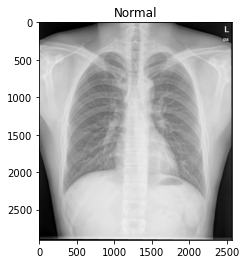

In [36]:
plt.title('Normal')
plt.imshow(image.load_img(np.random.choice(normal)))
plt.show()

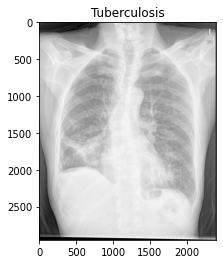

In [37]:
plt.title('Tuberculosis')
plt.imshow(image.load_img(np.random.choice(tuberculosis)))
plt.show()

# Image Processing and Data Partition into Train and Test

In [30]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
train_data_gen = datagen.flow_from_directory(directory='/content/dataset/train',
                                             target_size = (img_width, img_height),
                                             class_mode = 'sparse')
test_data_gen = datagen.flow_from_directory(directory='/content/dataset/test',
                                            target_size = (img_width, img_height),
                                             class_mode = 'sparse',)

Found 595 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


# Deep Learning Model

In [ ]:
model = Sequential()

#convolution 
model.add(Conv2D(32, (3,3), input_shape = (img_width, img_height, 3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(2,2))

#Dense 
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(228, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(270, activation='relu'))
model.add(Dropout(0.3))



model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
r = model.fit_generator(generator=train_data_gen, 
                              steps_per_epoch=len(train_data_gen),
                              epochs=20, 
                              validation_data= test_data_gen, 
                              validation_steps = len(test_data_gen))

Epoch 1/20
19/19 [==============================] - 67s 4s/step - loss: 0.7020 - accuracy: 0.4807 - val_loss: 0.6928 - val_accuracy: 0.5075
Epoch 2/20
19/19 [==============================] - 64s 3s/step - loss: 0.6930 - accuracy: 0.5059 - val_loss: 0.6899 - val_accuracy: 0.5075
Epoch 3/20
19/19 [==============================] - 63s 3s/step - loss: 0.6711 - accuracy: 0.6437 - val_loss: 0.5222 - val_accuracy: 0.7612
Epoch 4/20
19/19 [==============================] - 64s 3s/step - loss: 0.6017 - accuracy: 0.7361 - val_loss: 0.5763 - val_accuracy: 0.8060
Epoch 5/20
19/19 [==============================] - 66s 3s/step - loss: 0.4944 - accuracy: 0.8118 - val_loss: 0.4543 - val_accuracy: 0.8134
Epoch 6/20
19/19 [==============================] - 65s 3s/step - loss: 0.4475 - accuracy: 0.8084 - val_loss: 0.4626 - val_accuracy: 0.8209
Epoch 7/20
19/19 [==============================] - 65s 3s/step - loss: 0.4480 - accuracy: 0.8218 - val_loss: 0.4474 - val_accuracy: 0.8060
Epoch 8/20
19/19 [==

# Analysis/Evaluation 

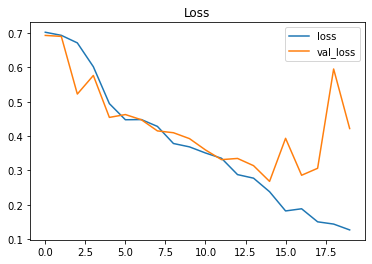

In [ ]:
plt.title('Loss')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

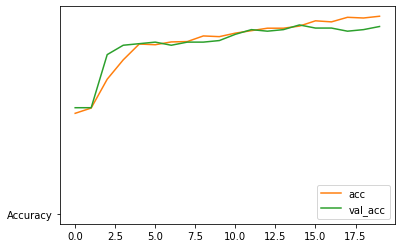

In [ ]:
plt.plot('Accuracy')
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

# Saving the Model


In [ ]:
model.save('Tuberculosis.h5')

In [ ]:
model = tf.keras.models.load_model("Tuberculosis.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('Tuberculosis.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8xfj1ktj/assets


INFO:tensorflow:Assets written to: /tmp/tmp8xfj1ktj/assets


9592916